In [8]:
#Written by Seth Talyansky
#later_getData function translated to Python by ChatGPT

import os
import numpy as np
import pandas as pd
import scipy.io

def later_getData(subjectTag='JT', dataDirectory=None, expressCutoff=0.0):
    """
    Python version of later_getData.m
    Loads subject data from either .mat or .csv and extracts reaction time subsets.
    """

    # Default data directory
    # if dataDirectory is None:
    #     dataDirectory = os.path.join(
    #         os.path.expanduser("~"),
    #         "Library", "CloudStorage", "Box-Box", "QNC", "LATERdata"
    #     )

    # Possible data file paths
    csv_path = '/Users/sethtal/Downloads/JT_RT_converted.csv'

    # Load data depending on file type
    if os.path.exists(csv_path):
        print(f"Loading data from CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        numdirSum = df['numdirSum'].to_numpy()
        tRxnSum = df['tRxnSum'].to_numpy()
        percorrSum = df['percorrSum'].to_numpy()
        decisionSum = df['decisionSum'].to_numpy()
        syncSum = df['syncSum'].to_numpy()
        labelSum = df['labelSum'].to_numpy()
    else:
        raise FileNotFoundError(f"No data file found for subject {subjectTag} in {dataDirectory}")

    # Define selection criteria
    Ltrials = (percorrSum == 1) & (tRxnSum > expressCutoff) & (tRxnSum < 1.2)

    # Create four data subsets (same as MATLAB logic)
    data_ = [
        tRxnSum[Ltrials & (numdirSum == -1) & (labelSum == 1)],   # Left, CP
        tRxnSum[Ltrials & (numdirSum == -1) & (labelSum != 1)],   # Left, no CP
        tRxnSum[Ltrials & (numdirSum == 1) & (labelSum == 1)],    # Right, CP
        tRxnSum[Ltrials & (numdirSum == 1) & (labelSum != 1)]     # Right, no CP
    ]

    labels_ = [
        "Left Choice, CP",
        "Left Choice, No CP",
        "Right Choice, CP",
        "Right Choice, No CP"
    ]

    return data_, labels_


# Step 1: Load RT Data
# For this example, we'll simulate some RT data.
# In real usage, you'd load actual RTs.
RTs = later_getData()

Loading data from CSV: /Users/sethtal/Downloads/JT_RT_converted.csv
([array([0.486722, 0.447101, 0.461715, ..., 0.377148, 0.353642, 0.270038]), array([0.427658, 0.478042, 0.407701, 0.392792, 0.33945 , 0.576767,
       0.459844, 0.423207, 0.465359, 0.473921, 0.462475, 0.438489,
       0.478422, 0.42922 , 0.444833, 0.4805  , 0.56745 , 0.779507,
       0.449639, 0.357387, 0.375784, 0.355616, 0.376171, 0.489103,
       0.461294, 0.424784, 0.444582, 0.583888, 0.462116, 0.484841,
       0.443402, 0.536847, 0.480386, 0.423062, 0.374804, 0.394774,
       0.420718, 0.466904, 0.413918, 0.427806, 0.446184, 0.393832,
       0.71465 , 0.476448, 0.746959, 0.525793, 0.477809, 0.591425,
       0.473638, 0.449208, 0.615513, 0.40705 , 0.463594, 0.394847,
       0.391592, 0.482178, 0.36234 , 0.478844, 0.343877, 0.357569,
       0.431396, 0.358628, 0.407172, 0.39153 , 0.373235, 0.407975,
       0.357664, 0.348117, 0.32095 , 0.360003, 0.384998, 0.504198,
       0.416723, 0.453806, 0.942731, 0.739312, 0.439

/var/folders/zs/vxqkq7993fxgv9_c3d0p1d2w0000gp/T/ipykernel_50086/563227970.py:13: RuntimeWarning: divide by zero encountered in log
  later_err_fcn = lambda fits: -np.sum(np.log(norm.pdf(1/RTs[0][c], fits[0]/fits[1], 1/fits[1])))


Best-fitting parameters: muR = 0.0010, deltaS = 1000.0000
Negative log-likelihood: inf
Best-fitting parameters: muR = 0.0010, deltaS = 1000.0000
Negative log-likelihood: inf
Best-fitting parameters: muR = 0.0010, deltaS = 1000.0000
Negative log-likelihood: inf
Best-fitting parameters: muR = 0.0010, deltaS = 1000.0000
Negative log-likelihood: inf
The answer is reasonable if the fit is close...


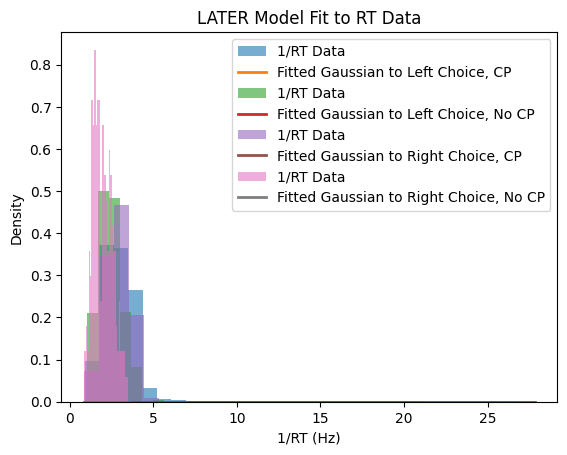

In [26]:
#ChatGPT used to translate code from MATLAB to Python and write plotting code for fit evaluation 
from scipy.optimize import minimize, Bounds, differential_evolution
from scipy.stats import norm
import matplotlib.pyplot as plt

for c in range(4):
    # Step 2: Define Objective Function
    # LATER assumes that 1/RT is normally distributed
    # mu = muR / deltaS
    # sigma = 1 / deltaS
    
    # Define as a lambda function like in MATLAB
    later_err_fcn = lambda fits: -np.sum(np.log(norm.pdf(1/RTs[0][c], fits[0]/fits[1], 1/fits[1])))
    
    # Step 3: Define Initial Conditions and Bounds
    lower_bounds = [0.001, 0.001]
    upper_bounds = [1000, 1000]

    # Heuristic initial values based on the data
    muR_init = np.mean(RTs[0][c])
    deltaS_init = 0.1
    initial_values = [muR_init, deltaS_init]
    
    # Step 4: Run the Fit using Global Optimization (Differential Evolution)
    # (since there's no GlobalSearch in scipy, DE is a good alternative)
    
    result = differential_evolution(
        func=later_err_fcn,
        bounds=(lower_bounds, upper_bounds),
        strategy='best1bin',
        maxiter=1000,
        polish=True
    )
    
    fits = result.x
    nllk = result.fun
    
    print(f"Best-fitting parameters: muR = {fits[0]:.4f}, deltaS = {fits[1]:.4f}")
    print(f"Negative log-likelihood: {nllk:.4f}")
    
    # Step 5: Evaluate the Fit
    
    # Compare the model prediction to the actual 1/RT distribution
    mu_fit = fits[0] / fits[1]
    sigma_fit = 1 / fits[1]
    
    x_vals = np.linspace(min(1/RTs[0][c]), max(1/RTs[0][c]), 200)
    pdf_vals = norm.pdf(x_vals, loc=mu_fit, scale=sigma_fit)
    
    plt.hist(1/RTs[0][c], bins=30, density=True, alpha=0.6, label="1/RT Data")
    plt.plot(x_vals, pdf_vals, label="Fitted Gaussian to %s"%RTs[1][c], linewidth=2)
    plt.xlabel("1/RT (Hz)")
    plt.ylabel("Density")
    plt.title("LATER Model Fit to RT Data")
    plt.legend()

print('The answer is reasonable if the fit is close...')